##Installing arff2pandas

In [1]:
!pip install -qq arff2pandas

##Downloading the dataset

In [2]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
10.6MB [00:00, 17.3MB/s]


In [3]:
!unzip -qq ECG5000.zip

##Importing Modules

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Loading the Datasets

In [5]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [6]:
train.shape

(500, 141)

In [7]:
train.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.40638

In [8]:
test.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,0.878836,0.831067,0.832466,0.790993,0.733184,0.675314,0.760751,0.645451,0.644724,0.593140,0.600701,0.496795,0.409546,0.330819,0.159581,0.200914,0.107753,-0.039165,-0.096833,-0.170630,-0.296952,-0.381269,-0.363097,-0.501362,-0.673076,-0.551881,-0.650941,-0.542608,-0.661102,-0.581184,...,0.912150,1.197038,1.525856,1.677409,1.493802,1.332885,1.033417,0.709380,0.504176,0.121977,-0.144692,-0.706222,-0.971959,-1.092812,-1.204838,-1.114166,-1.087325,-1.285353,-1.248159,-1.210142,-1.278470,-1.278924,-1.376985,-1.232817,-1.189943,-1.344416,-1.239010,-1.174265,-0.699666,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,-0.493585,-0.424566,-0.443613,-0.347533,-0.429206,-0.419432,-0.420668,-0.498734,-0.410890,-0.443809,-0.463833,-0.499894,-0.524206,-0.616694,-0.606410,-0.565365,-0.661417,-0.603203,-0.695499,-0.717034,-0.696853,-0.734096,-0.792403,-0.820478,-0.727217,-0.828315,-0.708753,-0.696388,-0.662056,-0.631873,...,1.167701,1.305410,1.500784,1.739557,1.977449,1.916066,1.899681,1.702459,1.579359,1.268397,1.021553,0.568299,0.150091,-0.044534,-0.090432,-0.144367,-0.131316,-0.110823,-0.088810,-0.095817,-0.082048,-0.053043,-0.189978,-0.111385,-0.128527,-0.047618,-0.016406,0.108356,0.293390,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,-0.842542,-0.829726,-0.790482,-0.785441,-0.835461,-0.796361,-0.771146,-0.815385,-0.735402,-0.798965,-0.679510,-0.683254,-0.739599,-0.815913,-0.902384,-0.813008,-0.855560,-0.793842,-0.853332,-0.843024,-0.844967,-0.917276,-0.979700,-1.031643,-0.958200,-1.008464,-1.043407,-1.009559,-1.001219,-0.953293,...,0.663832,0.939063,1.196396,1.238014,1.310015,1.594162,1.836205,1.873225,1.960083,1.803756,1.718425,1.592971,1.344949,1.166471,0.695750,0.279590,0.180811,0.201507,0.191033,0.153371,0.178460,0.263660,0.271427,0.271596,0.356748,0.257862,0.277773,0.331739,0.384731,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,-0.589493,-0.455109,-0.201613,0.055583,-0.095133,0.023464,-0.291556,-0.405063,-0.269354,-0.197477,-0.032429,-0.501257,-0.399656,-0.283003,-0.202945,-0.570158,-0.777244,-0.419418,-0.375513,-0.638091,-0.969082,-0.780202,-0.617075,-0.898172,-0.970493,-0.774366,-0.650623,-0.680303,-1.015144,-0.970932,...,1.800425,2.146134,1.995252,1.892413,2.119649,1.480067,1.071041,1.186209,0.863298,0.301564,-0.126937,-0.301484,-0.436105,-0.284822,-0.224644,-0.

In [9]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [10]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.

##Data preprocessing steps

In [12]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [13]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [14]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

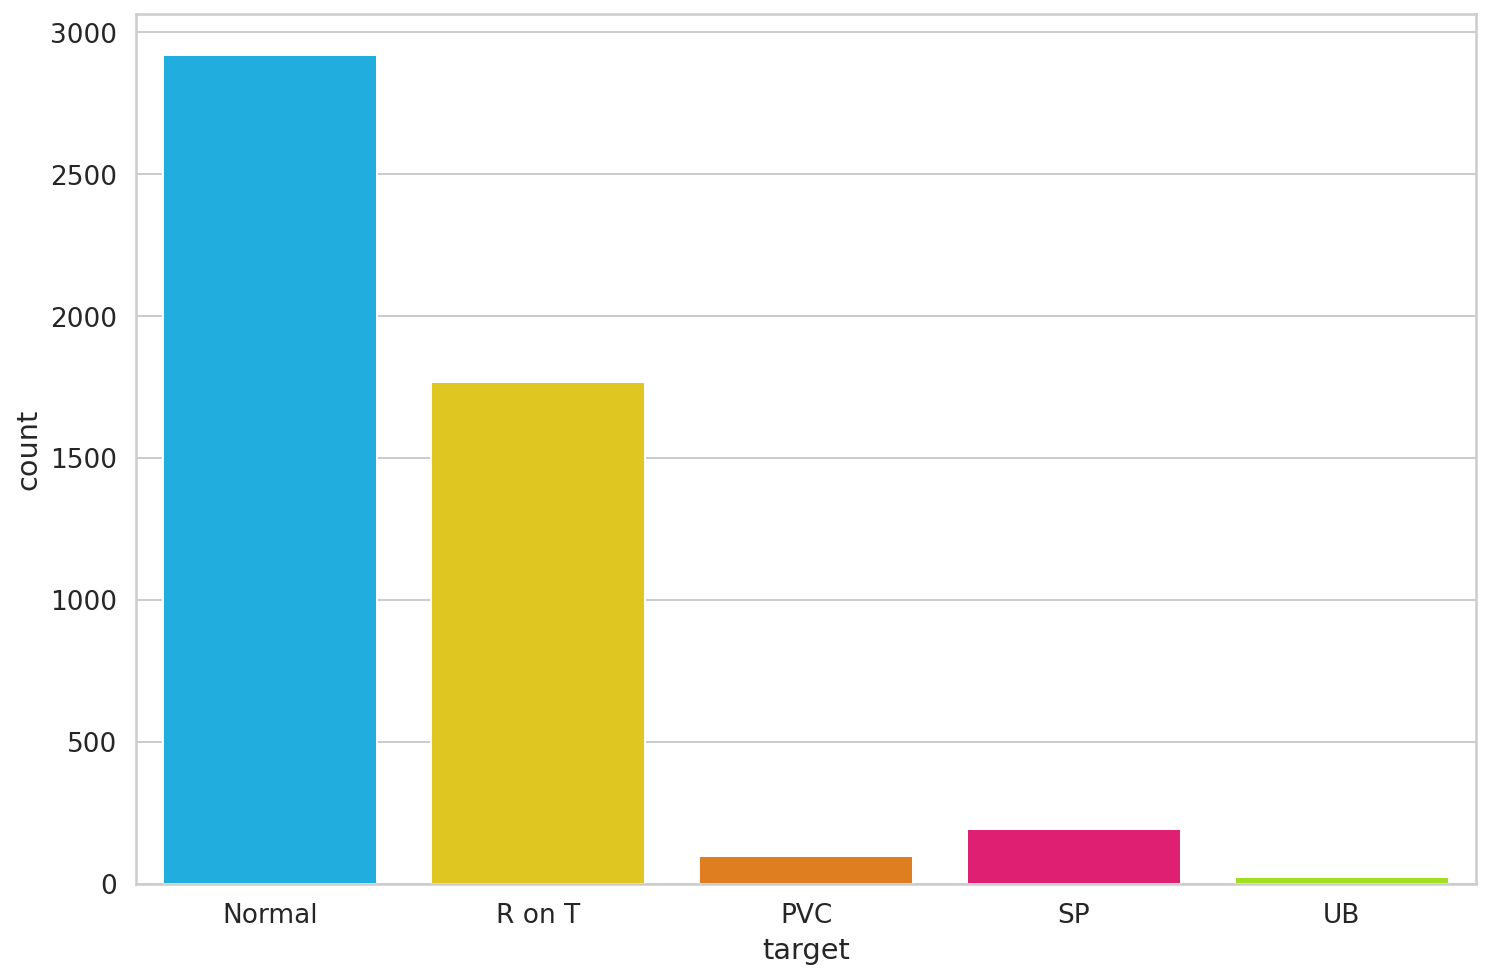

In [15]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

Building a plot function

In [16]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

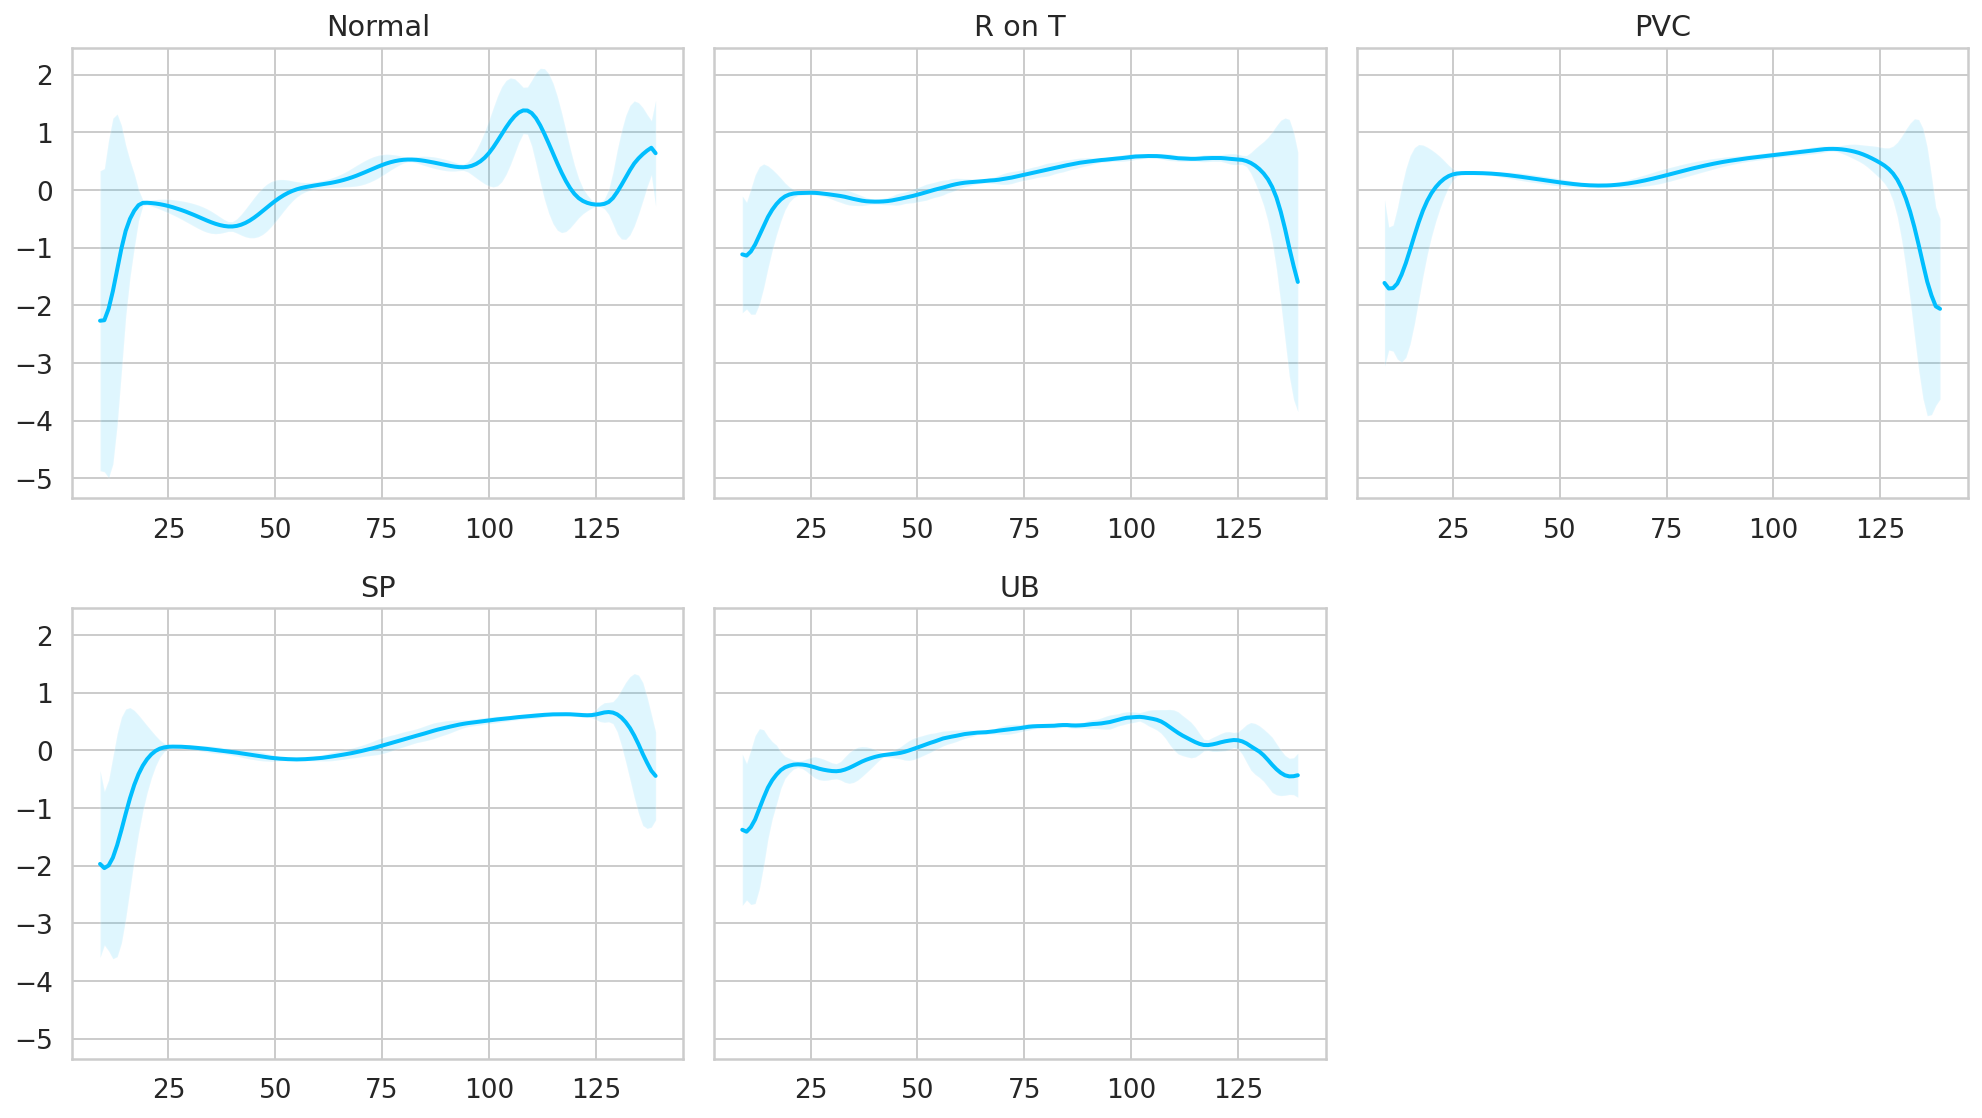

In [17]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Dropping 'target' column

In [18]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [19]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [20]:
normal_df = normal_df.values
anomaly_df = anomaly_df.values

Splitting our dataset

In [21]:
train_df, val_df = train_test_split( normal_df, test_size=0.15, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)

In [22]:
print(f"The Shape of train_df = {train_df.shape}")
print(f"The Shape of val_df = {val_df.shape}")
print(f"The Shape of test_df = {test_df.shape}")
print(f"The Shape of anomaly_df = {anomaly_df.shape}")

The Shape of train_df = (2481, 140)
The Shape of val_df = (293, 140)
The Shape of test_df = (145, 140)
The Shape of anomaly_df = (2081, 140)


##Building our Auto-Encoder

In [23]:
shape = (2481, 140)
train_df = train_df.reshape((1, *shape))
train_df.shape

(1, 2481, 140)

In [24]:
val_shape = (293, 140)
val_df = val_df.reshape((1, *val_shape))
val_df.shape

(1, 293, 140)

In [87]:
auto_encoder = Sequential([
    LSTM(256, input_shape = (None, train_df.shape[2]), return_sequences = True),
    LSTM(128,  return_sequences = True),
    LSTM(128,  return_sequences = True),
    LSTM(256,  return_sequences = True),
    Dense(train_df.shape[2])]
)

In [88]:
auto_encoder.compile(loss = "mean_squared_error", optimizer = 'adam')
auto_encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, None, 256)         406528    
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 128)         197120    
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 256)         394240    
_________________________________________________________________
dense_4 (Dense)              (None, None, 140)         35980     
Total params: 1,165,452
Trainable params: 1,165,452
Non-trainable params: 0
_________________________________________________________________


In [89]:
epochs = 150
history = auto_encoder.fit(train_df, train_df,epochs = epochs, validation_data = (val_df, val_df)) 

Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 0.9997 - val_loss: 0.8936
Epoch 2/150
1/1 [==============================] - 0s 89ms/step - loss: 0.8909 - val_loss: 0.7377
Epoch 3/150
1/1 [==============================] - 0s 95ms/step - loss: 0.7307 - val_loss: 0.5705
Epoch 4/150
1/1 [==============================] - 0s 89ms/step - loss: 0.5613 - val_loss: 0.4407
Epoch 5/150
1/1 [==============================] - 0s 95ms/step - loss: 0.4323 - val_loss: 0.3481
Epoch 6/150
1/1 [==============================] - 0s 102ms/step - loss: 0.3413 - val_loss: 0.2868
Epoch 7/150
1/1 [==============================] - 0s 90ms/step - loss: 0.2815 - val_loss: 0.2520
Epoch 8/150
1/1 [==============================] - 0s 90ms/step - loss: 0.2483 - val_loss: 0.2369
Epoch 9/150
1/1 [==============================] - 0s 96ms/step - loss: 0.2347 - val_loss: 0.2339
Epoch 10/150
1/1 [==============================] - 0s 92ms/step - loss: 0.2330 - val_loss: 0.2357
Epoch 11/150
1/1 [==

In [90]:
epochs_ = [d for d in range(1, epochs+1)]
loss = history.history['loss']
val_loss = history.history['val_loss']

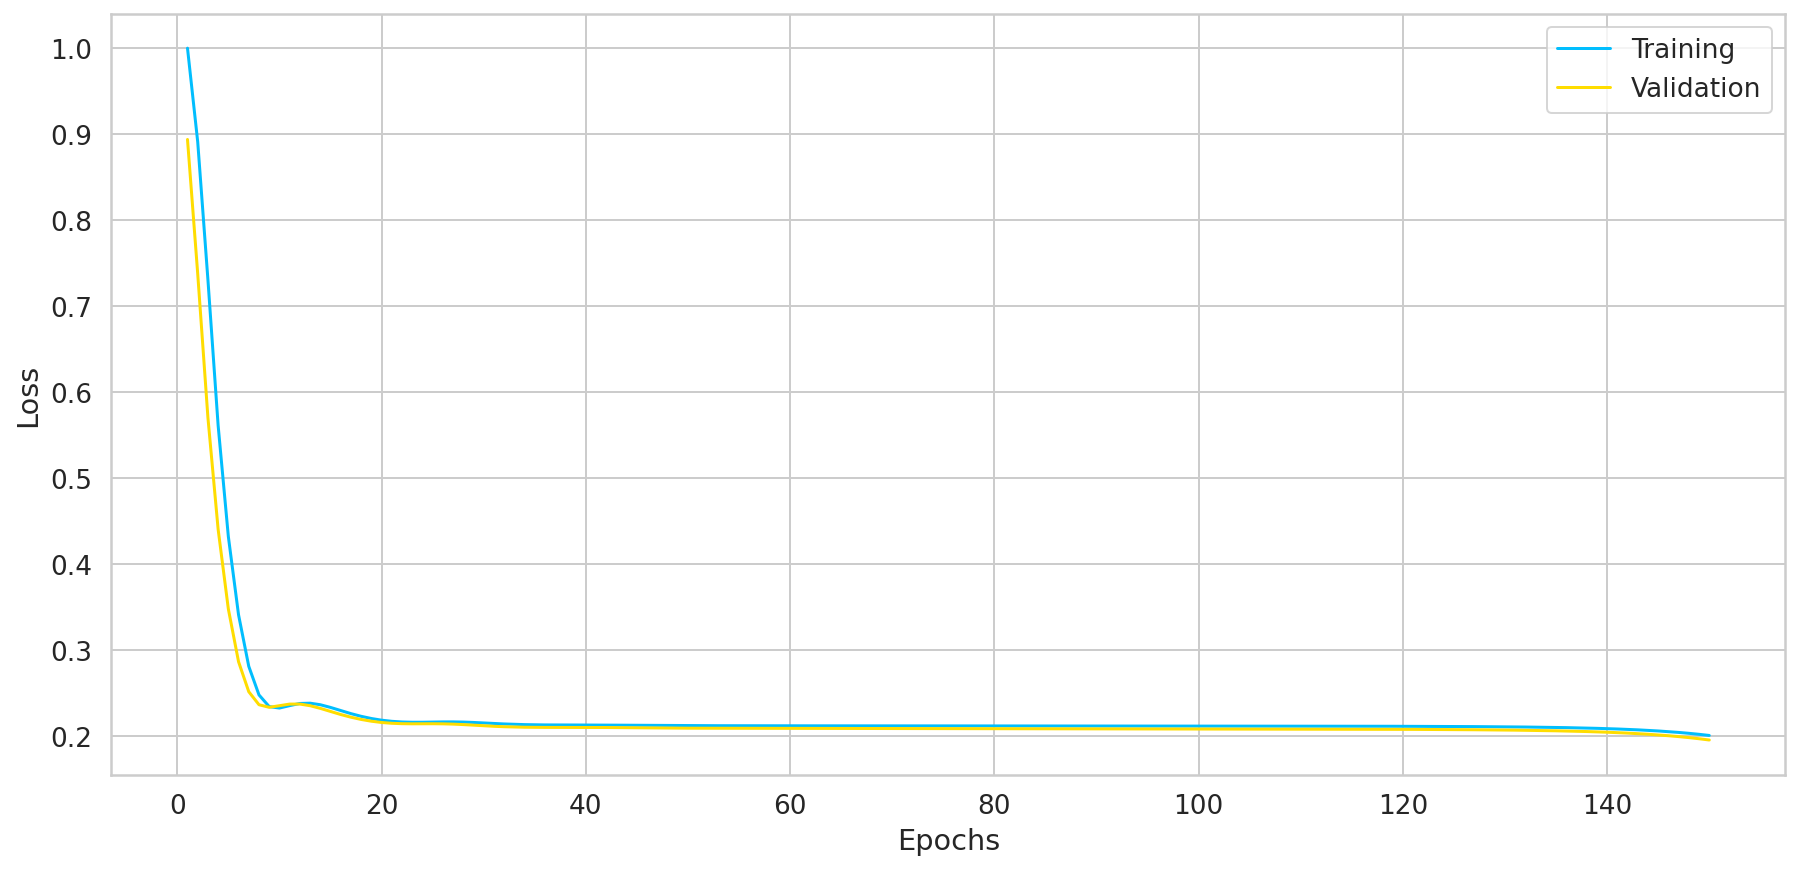

In [91]:
plt.figure(figsize=(15, 7))
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.plot(epochs_, loss, label = 'Training')
plt.plot(epochs_, val_loss, label = 'Validation')
plt.legend()
plt.show()

##Saving model architecture and weights

In [92]:
auto_encoder_arch = auto_encoder.to_json()
with open("auto_enc_.json", "w+") as file:
  file.write(auto_encoder_arch)

In [93]:
auto_encoder.save_weights("auto_enc.h5")

##Plotting Normal ECG

In [94]:
normal_ecg = df[df.target == str(CLASS_NORMAL)].drop(['target'], axis = 1)
normal_ecg.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.573868,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.444721,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.340341,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.9591

Plotting the averaged Normal ECG

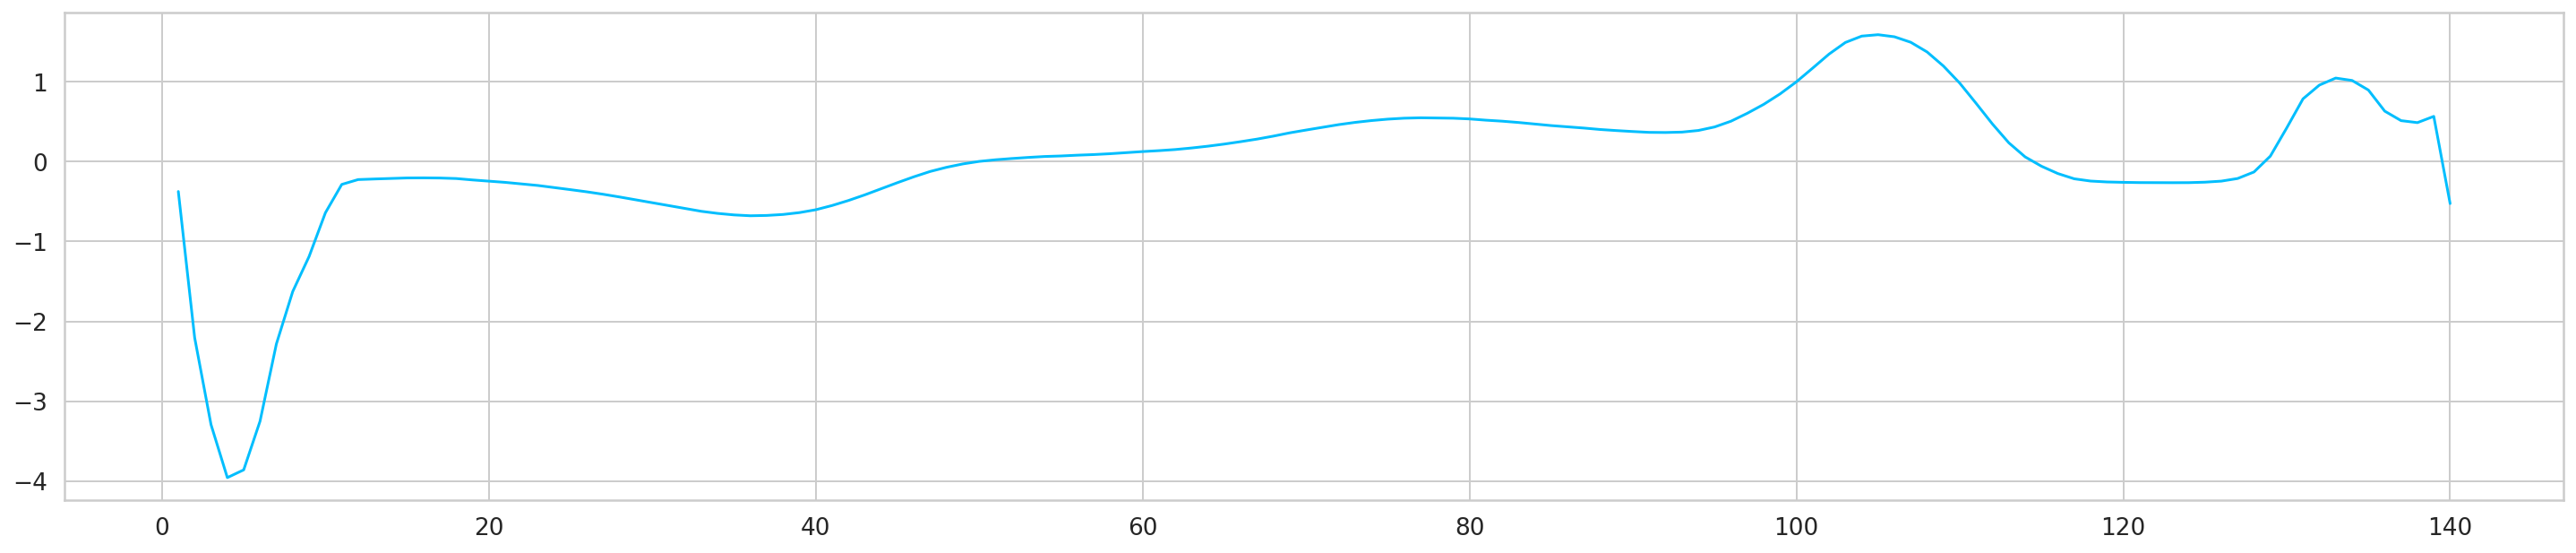

In [95]:
averaged_ecg = list(map(lambda x:x/normal_ecg.shape[0], normal_ecg.sum(axis = 0).tolist()))
plt.figure(figsize=(25, 5))
points = [d for d in range(1, len(averaged_ecg)+1)]
plt.plot(points, averaged_ecg)
plt.show()

In [96]:
len(averaged_ecg)

140

##For threshold

**For defining threshold, we are computing the minimum loss or variance we are getting by comparing the normal ecg waveforms with the model predicted normal waveforms.**

In [97]:
from sklearn.metrics import mean_squared_error

train_df.shape

(1, 2481, 140)

In [98]:
data_pred = auto_encoder.predict(train_df)
data_pred.shape

(1, 2481, 140)

reshaping our predicted data for calculating mean squared error(mse)

In [99]:
data_pred_reshaped = data_pred.reshape((data_pred.shape[1], data_pred.shape[2]))
data_pred_reshaped.shape

(2481, 140)

In [100]:
data_train = train_df.reshape((data_pred.shape[1], data_pred.shape[2]))
data_train.shape

(2481, 140)

In [101]:
data_train[0]

array([ 2.4589672e-01, -2.3817315e+00, -3.3791140e+00, -4.1505601e+00,
       -4.3621519e+00, -3.6047352e+00, -2.2038300e+00, -1.6929113e+00,
       -1.4115929e+00, -4.5316030e-01, -2.4718458e-01, -3.0593653e-01,
       -3.0416616e-01, -2.8427074e-01, -3.1556546e-01, -3.4547117e-01,
       -2.9497476e-01, -2.6480855e-01, -2.9031097e-01, -3.4224546e-01,
       -2.9521725e-01, -2.9572471e-01, -3.0981765e-01, -3.0440770e-01,
       -2.9467071e-01, -2.8536740e-01, -5.3137913e-01, -4.3835813e-01,
       -4.7724879e-01, -5.1942091e-01, -6.5863824e-01, -6.1886620e-01,
       -6.9422330e-01, -7.1705394e-01, -7.0026692e-01, -7.2060915e-01,
       -8.0252504e-01, -6.7490090e-01, -6.7998123e-01, -6.5681081e-01,
       -5.8269128e-01, -5.0120398e-01, -4.1481609e-01, -4.1920318e-01,
       -1.5492821e-01, -1.7647425e-01, -2.0756548e-01, -9.3014352e-02,
       -8.7010712e-02,  4.1239922e-03,  8.7061190e-02,  6.0389259e-02,
        4.2211040e-02,  8.1857844e-02,  1.4818823e-01,  1.3403217e-01,
      

In [102]:
data_pred[0][0]

array([-3.51812877e-02, -1.72562912e-01, -2.45299309e-01, -3.09801966e-01,
       -3.22340131e-01, -2.66736537e-01, -1.90209553e-01, -1.55943722e-01,
       -1.18095115e-01, -5.11919633e-02, -1.45178605e-02, -1.13849817e-02,
       -2.28418186e-02, -2.64735837e-02, -1.94060914e-02, -1.12732770e-02,
       -2.24800520e-02,  7.93515006e-04, -6.93785213e-03, -3.49552408e-02,
       -5.01029417e-02, -2.71320287e-02, -2.54569575e-02, -5.11779264e-02,
       -3.06132659e-02, -3.87860201e-02, -3.68265025e-02, -3.80483344e-02,
       -5.04379347e-02, -5.29150143e-02, -5.40074967e-02, -7.34380931e-02,
       -4.92851213e-02, -6.49227202e-02, -5.56354038e-02, -5.86063303e-02,
       -5.41980080e-02, -6.10350445e-02, -5.36732748e-02, -5.09079918e-02,
       -5.33315577e-02, -5.84382154e-02, -2.95771044e-02, -2.55736690e-02,
       -3.45436782e-02, -2.41125580e-02, -1.99360419e-02,  1.30584436e-02,
       -2.97518298e-02,  5.46940463e-03, -7.95597211e-03, -3.81572172e-05,
        1.71736861e-03, -

In [114]:
losses = []
for i in range(data_train.shape[0]):
  loss = mean_squared_error(data_train[i], data_pred[0][i])
  losses.append(loss)
threshold = min(losses)
print(threshold)    

0.023132063712041705


##Comparing

**Our model will basically give a reconstructed form for a input waveform.We have trained it for only normal ECG waveforms, so given an ECG will result in a reconstruction error. Now, we just have to compare the recontruction error with our threshold, if it is comparitively less then we will call it a normal ECG or else it will be called as a Abnormal ECG.**

In [115]:
anomaly_df.shape

(2081, 140)

In [116]:
anomaly_df[0]

array([-3.2123648e-01, -1.4613673e+00, -2.3659664e+00, -2.8126436e+00,
       -3.0689740e+00, -3.2237711e+00, -3.0890627e+00, -2.7085123e+00,
       -2.1058886e+00, -1.5876355e+00, -1.4050841e+00, -1.2283728e+00,
       -9.2603107e-01, -6.4871788e-01, -6.4638488e-01, -6.1944078e-01,
       -5.3507384e-01, -5.0151139e-01, -5.8309792e-01, -5.3548585e-01,
       -4.6790041e-01, -4.9460524e-01, -4.5950153e-01, -4.9152920e-01,
       -4.5270156e-01, -4.3761739e-01, -4.4028853e-01, -4.8815657e-01,
       -4.3548640e-01, -3.9139435e-01, -4.4198196e-01, -4.0662964e-01,
       -4.9851051e-01, -4.2888863e-01, -4.4031483e-01, -4.4817833e-01,
       -4.8973542e-01, -4.8349145e-01, -5.0665889e-01, -4.6152355e-01,
       -4.6898831e-01, -5.1140948e-01, -4.6818377e-01, -4.0443028e-01,
       -4.4941130e-01, -4.1738669e-01, -4.0161728e-01, -4.0626093e-01,
       -3.9237985e-01, -3.3114320e-01, -3.2597597e-01, -2.4140166e-01,
       -2.1765651e-01, -1.1584144e-01, -1.2836376e-01, -7.1403849e-02,
      

reshaping the data_anomaly because our model expects a 3D tensor

In [117]:
data_anomaly = anomaly_df.reshape((1, *anomaly_df.shape))
data_anomaly.shape

(1, 2081, 140)

After prediction, reshaping our prediction data (data_anamoly_pred) to a 2D tensor so as to compute the mse and check model's prediction

In [118]:
data_anomaly_pred = auto_encoder.predict(data_anomaly)
data_anomaly_pred = data_anomaly_pred.reshape((*anomaly_df.shape))
data_anomaly_pred.shape

(2081, 140)

In [119]:
data_anomaly_pred[0]

array([-2.63642948e-02, -1.17498443e-01, -1.64954901e-01, -2.06601962e-01,
       -2.16718733e-01, -1.78642511e-01, -1.29827499e-01, -1.06388375e-01,
       -8.11156183e-02, -3.74453440e-02, -9.03501268e-03, -1.04717556e-02,
       -1.68776270e-02, -1.66438669e-02, -1.55233946e-02, -1.06424382e-02,
       -1.63428150e-02,  1.19302096e-03, -4.88997716e-03, -2.69339718e-02,
       -3.69794182e-02, -2.21894998e-02, -1.89387742e-02, -3.78091633e-02,
       -2.10712701e-02, -2.57231183e-02, -2.77412888e-02, -2.69297194e-02,
       -3.64351347e-02, -3.70022766e-02, -3.92837487e-02, -5.35130948e-02,
       -3.23868506e-02, -4.57265228e-02, -4.02296111e-02, -4.07367051e-02,
       -3.91307622e-02, -4.06849682e-02, -3.77078280e-02, -3.61425579e-02,
       -3.91583629e-02, -4.31728475e-02, -2.15674378e-02, -1.86522510e-02,
       -2.76425891e-02, -2.03198902e-02, -1.35021703e-02,  1.01956232e-02,
       -1.73780061e-02,  4.93394677e-03, -8.90913047e-03, -3.37905018e-03,
        2.38039531e-03, -

In [120]:
anomaly_df.shape[0]

2081

In [121]:
anomaly_count = 0
normal_count = 0
losses = []
for j in range(anomaly_df.shape[0]):
  loss = mean_squared_error(anomaly_df[j], data_anomaly_pred[j])
  losses.append(loss)
  if loss>threshold:
    anomaly_count += 1
  else:
    normal_count += 1      

In [122]:
losses

[0.9234236074637838,
 0.7281556467055585,
 0.9928482239603543,
 0.547718715196843,
 0.6868692331722744,
 1.4037797154669254,
 1.096483504028997,
 0.6638280857224377,
 0.8277808225658324,
 1.183404646584215,
 0.6932226064541352,
 1.059645796408545,
 1.0600629571054676,
 1.039991110690032,
 1.2435348655325174,
 1.2044425617113819,
 0.8752773475022391,
 1.2956458822042398,
 0.6953149077512581,
 1.3232796970549747,
 1.3109073781119853,
 0.9796070813418298,
 0.7113269154503788,
 0.8804597500791669,
 0.7948274487091278,
 1.0292119911531095,
 0.9836345646625089,
 1.405406943466206,
 0.6829037365639423,
 1.2072980291871895,
 0.8471767813164709,
 0.9546569899870258,
 1.6903881990544563,
 2.062336170973797,
 0.6172991359447633,
 1.382145668624056,
 0.6763546151115599,
 1.4570322543241072,
 0.6512133175809318,
 0.8293839814713921,
 1.0288421433136266,
 1.43308913828937,
 0.9791920307356388,
 0.974466760540027,
 0.9055541279850873,
 1.4342636865294218,
 1.0463596427771773,
 0.835205887541976,
 0.8

In [125]:
print(f"Out of {anomaly_count + normal_count} abnormal ecg data, we got {anomaly_count} abormal ecgs and {normal_count} normal ecgs")

Out of 2081 abnormal ecg data, we got 2081 abormal ecgs and 0 normal ecgs
